In [1]:
import iris
import iris.coord_categorisation as coord_cat
import sys
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import iris.quickplot as qplt
import matplotlib
import numpy as np
import matplotlib.cm as cm
import matplotlib.mlab as mlab
from matplotlib import gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import Normalize
import scipy
from scipy import stats
from collections import Counter
from scipy.fftpack import fft, fftfreq
import sys
import matplotlib.animation as animation
import csv
import pandas as pd
from datetime import datetime
import math

In [4]:
##functions
## function to perform 1 timestep of the SRI model given beta, gamma, N
## and values of populations from previous timestep, returns changes in each probability of population (S, R, I)
def Timestep(N, beta, gamma, S_m, R_m, I_m):
    deltaS = -1 * beta * I_m * S_m/N
    deltaR = gamma * I_m
    deltaI = beta * I_m * S_m/N - gamma * I_m
    
    return deltaS, deltaR, deltaI


def run_sim(N, beta, gamma, N_weeks, s0, pia, false_symp):
    #initial vals for populations
    S = np.array([N - I[0]])
    R = np.zeros([1])
    symp0 = N*s0
    symp = np.array([symp0])
    I = symp[0]/(1-pi_a)
    symp_new_cases = np.array([symp0])
    
    #loop over number of timesteps, incrementing S,R,I and symp.
    for i in range(1, N_weeks):
        deltaS, deltaR, deltaI = Timestep(N, beta, gamma, S[-1], R[-1], I[-1])
        S = np.append(S, S[-1] + deltaS)
        R = np.append(R, R[-1] + deltaR)
        I = np.append(I, I[-1] + deltaI)
        
        #find symptomatic number
        symp = np.append(symp, (1-pia)*I[-1]/N)
        
        #calculate number of new symptomatic cases for this timestep
        symp_new_cases = np.append(symp_new_cases, symp[-1] - symp[-2] + deltaR/N)
        
    return S,R,I,symp,symp_new_cases

In [9]:
# Simplest way to read csv (which doesn't work for multi-level columns)
df = pd.read_csv('total-cases-covid-19.csv')
data = df.values
GB = df.loc[df['Code'] == 'GBR'].values[:,3]


print(GB_tests)

[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan 11896.0 11924.0 13457.0 14293.0 15899.0 12733.0 13684.0 14419.0
 16443.0 18843.0 17737.0 17650.0 14506.0 14567.0 15991.0 18489.0 20906.0
 21081.0 21249.0 19316.0 17365.0 22763.0 23073.0 28024.0 28225.0 29058.0
 31610.0 31453.0 45263.0 65643.0 83143.0 74142.0 63559.0 68203.0 71764.0
 65803.0 73277.0 76741.0 74836.0 74586.0 73541.0 67116.0 72368.0 80713.0
 81595.0 88046.0 88262.0 75290.0 63028.0 79653.0 81403.0 93398.0 84060.0
 79902.0 51844.0 69381.0 63765.0 70329.0 84634.0 95550.0 89867.0 75263.0
 64763.0 86267.0 96674.0 95445.0 98667.0 90562.0 83790.0 66769.0 91606.0
 97852.0 98913.0 95216.0 96044.0 66688.0 67808.0 78962.

In [12]:
fig = plt.figure()
plt.plot(np.arange(len(GB_new_cases)), GB_new_cases*67810208)
plt.plot(np.arange(len(GB_tests)), GB_tests)

plt.ylabel('new cases')
plt.title('UK New Cases')
plt.xticks([1,30,61,92],['01/Feb', '01/Mar', '01/Apr', '01/May'])
plt.yticks(np.arange(1000,10000,1000),np.arange(1000,10000,1000))
plt.show()
fig.savefig('./covid_optimisations/figures_for_paper/real_new_case_data.png', dpi = 250)

gamma = 1 - 0.5**(1/4.)


NameError: name 'GB_new_cases' is not defined

<Figure size 432x288 with 0 Axes>

0.24483807254621992
67810208.0
67810208.0
67810208.0
67810208.0
67810208.0
67810208.0
67810208.00000001
67810208.00000001
67810208.0
67810208.0
67810208.00000001
67810208.0
67810208.00000001
67810208.00000001
67810208.00000001
67810208.00000001
67810208.00000001
67810208.00000001
67810208.00000003
67810208.00000001
67810208.00000003
67810208.00000003
67810208.00000003
67810208.00000003
67810208.00000003
67810208.00000003
67810208.00000001
67810208.00000001
67810208.00000001
67810208.00000001
67810208.00000001
67810208.00000003
67810208.00000003
67810208.00000001
67810208.00000001
67810208.0
67810208.00000001
67810208.00000001
67810208.00000001
67810208.0
67810208.0
67810208.00000001
67810208.0
67810208.0
67810208.0
67810207.99999999
67810208.0
67810208.0
67810208.0
67810208.0
67810208.0
67810208.0
67810208.0
67810208.0
67810208.0
67810208.0
67810208.0
67810208.0
67810208.0
67810208.0
67810208.0
67810208.00000001
67810208.00000001
67810208.00000001
67810208.0
67810208.0
67810208.0
67810

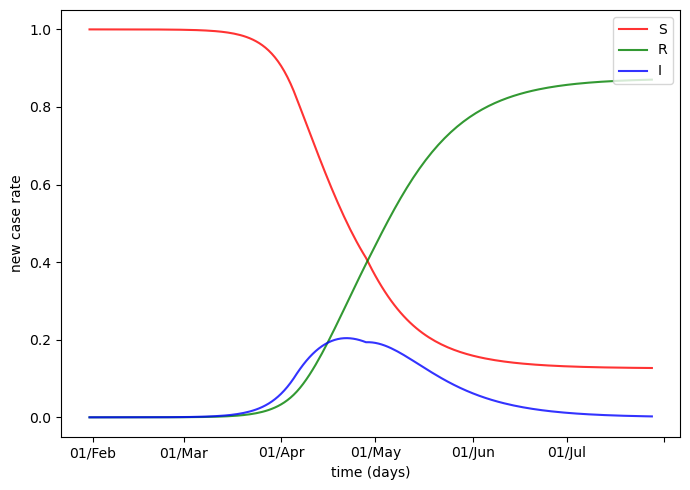

In [6]:
#modified version of the run_sim function used to a step_function beta
def run_sim(N, beta0, gamma, N_days, s0, pia, false_symp, beta_step, N_lockdown, mode):
    #initial vals for populations
    R = np.zeros([1])
    symp0 = s0
    symp = np.array([symp0])
    I = np.array([symp[0]*N/(1-pia)])
    S = np.array([N - I[0]])
    symp_new_cases = np.array([symp0])
    #loop over number of timesteps, incrementing S,R,I and symp.
    k = np.log(2)/3

    for i in range(1, N_days):
        if i < N_lockdown + 14:
            beta = beta0
        else:
            if mode == 'step':
                beta = beta0 - beta_step
            if mode == 'decay':
                k = np.log(2)/3
                beta = beta0 - beta_step * (1 - np.exp(-(i - (N_lockdown + 14))*k))
        
        if i > 88:
            beta = beta0 - 0.5*beta_step
        
        if split_betas == True:
            beta = beta*((1-pia) + 0.75*pia)
        deltaS, deltaR, deltaI = Timestep(N, beta, gamma, S[-1], R[-1], I[-1])
        S = np.append(S, S[-1] + deltaS)
        R = np.append(R, R[-1] + deltaR)
        I = np.append(I, I[-1] + deltaI)
        print(S[-1]+R[-1]+I[-1])
        symp = np.append(symp, (1-pia)*I[-1]/N + false_symp*(S[-1]/N + R[-1]/N))
        #calculate number of new symptomatic cases for this timestep
        symp_new_cases = np.append(symp_new_cases, symp[-1] - symp[-2] + (1 - pia)*deltaR/N)
        #print symp[-1], symp[-2], symp_new_cases[-1], deltaR
    return S,R,I,symp,symp_new_cases

### exploring the variability of the total symptomatic curve with pia
def pia_and_beta_vs_symp(beta0, pia_max, beta_step, pia_step, beta_drop_max, real_symp_new_cases, mode):
    pias = np.arange(0,pia_max,pia_step)
    beta_drops = np.arange(0,beta_drop_max + beta_step, beta_step)
    RMS = np.zeros([len(pias),len(beta_drops)])

    for i in range(len(pias)):
        for j in range(len(beta_drops)):
            print(pias[i], beta_drops[j])
            S,R,I,symp,symp_new_cases = run_sim(N, beta0, gamma, N_days, s0, pias[i], false_symp, beta_drops[j], N_lockdown, mode)
            RMS[i,j] = np.sqrt(np.mean((real_symp_new_cases - symp_new_cases)**2))
    return pias, beta_drops, RMS



#parameters converted to day units of time
gamma = 1 - 0.5**(1/8.)

#N_days = len(GB_new_cases)
N = 67810208.
s0 = 2./N
false_symp = 0
pia_max = 1
N_lockdown = 52
split_betas = False
R0 =  2.95
beta0 = gamma*R0
print(beta0)




#now use the optimal values for beta step down and pia to run the model forward in time past present day
n_projection = 180
S,R,I,symp,symp_new_cases = run_sim(N, beta0, gamma, n_projection, s0, 0.996, false_symp, beta0 - 0.1598, N_lockdown, 'decay')
alpha = 0.8
fig = plt.figure(figsize = (7,5), dpi = 100)
plt.plot(np.arange(n_projection), S[0:n_projection]/N, label = 'S', color = 'r', alpha = alpha)
plt.plot(np.arange(n_projection), R[0:n_projection]/N, label = 'R', color = 'g', alpha = alpha)
plt.plot(np.arange(n_projection), I[0:n_projection]/N, label = 'I', color = 'b', alpha = alpha)


#plt.plot(np.arange(n_projection), symp_new_cases[0:n_projection], label = '$y_{st}$', color = colors[2], alpha = alpha)
#plt.plot(np.arange(len(GB_new_cases)), GB_new_cases, label = 'data')
#plt.plot(np.arange(n_projection), I[0:n_projection]/N, label = 'I', color = colors[2], alpha = alpha)
#plt.plot(np.arange(n_projection), symp[0:n_projection], label = 'symp', color = colors[3], alpha = alpha)
plt.xlabel('time (days)')
plt.ylabel('new case rate')
plt.xticks([1,30,61,91,122,152,183],['01/Feb', '01/Mar', '01/Apr', '01/May', '01/Jun', '01/Jul'])
plt.legend(loc = 1)
plt.tight_layout()
plt.show()





#run optimisation
#pias, beta_drops, RMS = pia_and_beta_vs_symp(beta0, 1, 0.01, 0.02, beta0, GB_new_cases, 'step')
#pias, beta_drops, RMS = pia_and_beta_vs_symp(beta0, 1, 0.01, 0.001, beta0, GB_new_cases, 'decay')


/Users/oscar/.local/lib/python2.7/site-packages/numpy/ma/core.py:6461: MaskedArrayFutureWarning: In the future the default for ma.minimum.reduce will be axis=0, not the current None, to match np.minimum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)
/Users/oscar/.local/lib/python2.7/site-packages/numpy/ma/core.py:6461: MaskedArrayFutureWarning: In the future the default for ma.maximum.reduce will be axis=0, not the current None, to match np.maximum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)


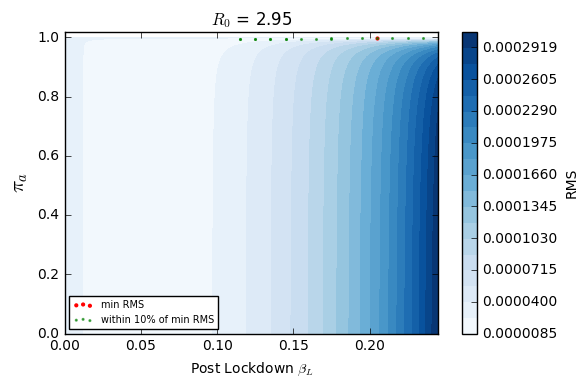

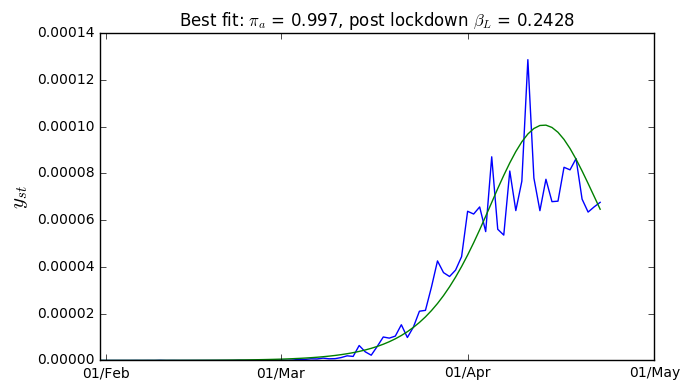

In [7]:
fig = plt.figure()
cs = plt.contourf( beta0 - beta_drops, pias, RMS, levels = np.linspace(np.min(RMS),np.max(RMS),20), cmap = 'Blues')
min_pia = pias[np.where(RMS == np.min(RMS))[0]]
min_beta = beta0 - beta_drops[np.where(RMS == np.min(RMS))[1]]
bottom5_pia = pias[np.where(RMS < 1.2*np.min(RMS))[0]]
bottom5_beta = beta0 - beta_drops[np.where(RMS < 1.2*np.min(RMS))[1]]
plt.scatter(min_beta, min_pia, color = 'red', s = 4, label = 'min RMS')
plt.scatter(bottom5_beta, bottom5_pia, color = 'g', alpha = 0.6, s = 1.5, label = 'within 10% of min RMS')
plt.ylim(0,1.02)
plt.xlim(0,beta0)
plt.xlabel('Post Lockdown $\\beta_L$')
plt.title('$R_0$ = 2.95')
plt.ylabel('$\pi_a$', fontsize = 15)
plt.colorbar(cs, label = 'RMS')
plt.legend(loc = 3, fontsize = 7)
plt.tight_layout()
plt.show()
#fig.savefig('./covid_optimisations/gamma_=_0.109_RMS_R0_=_' + str(R0) +'latest_data.png', dpi = 200)

fig = plt.figure(figsize = (7,4), dpi = 100)
S,R,I,symp,symp_new_cases = run_sim(N, beta0, gamma, N_days, s0, 0.997, false_symp, beta0 - 0.2428, N_lockdown, 'decay')
plt.plot(np.arange(len(GB_new_cases)), GB_new_cases)
plt.plot(np.arange(len(symp_new_cases)), symp_new_cases)
plt.ylabel('$y_{st}$', fontsize = 15)
plt.xticks([1,30,61,92],['01/Feb', '01/Mar', '01/Apr', '01/May'])
plt.title('Best fit: $\pi_a$ = ' + str(round(min_pia[0], 4)) + ', post lockdown $\\beta_L$ = 0.2428')
plt.tight_layout()
plt.show()
#fig.savefig('./covid_optimisations/gamma_=_0.109_best_fit_R0_=_' + str(R0) +'latest_data.png', dpi = 200)


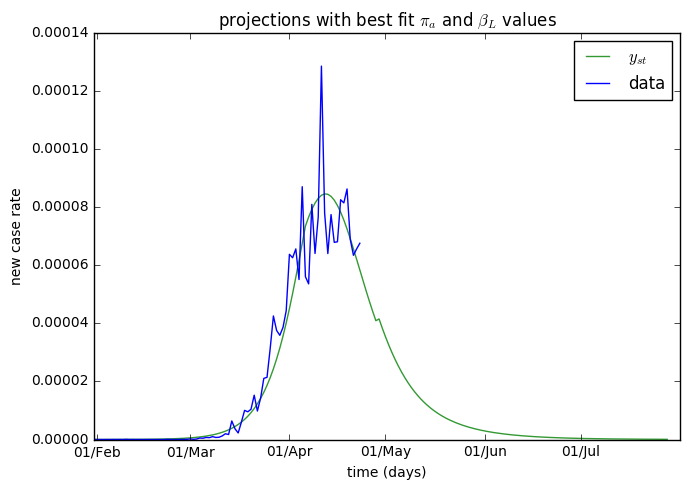

In [810]:
#now use the optimal values for beta step down and pia to run the model forward in time past present day
n_projection = 180
S,R,I,symp,symp_new_cases = run_sim(N, beta0, gamma, n_projection, s0, 0.997, false_symp, beta0 - 0.2048, N_lockdown, 'decay')
alpha = 0.8
fig = plt.figure(figsize = (7,5), dpi = 100)
#plt.plot(np.arange(n_projection), S[0:n_projection]/N, label = 'S', color = colors[0], alpha = alpha)
#plt.plot(np.arange(n_projection), R[0:n_projection]/N, label = 'R', color = colors[1], alpha = alpha)
plt.plot(np.arange(n_projection), symp_new_cases[0:n_projection], label = '$y_{st}$', color = colors[2], alpha = alpha)
plt.plot(np.arange(len(GB_new_cases)), GB_new_cases, label = 'data')
#plt.plot(np.arange(n_projection), I[0:n_projection]/N, label = 'I', color = colors[2], alpha = alpha)
#plt.plot(np.arange(n_projection), symp[0:n_projection], label = 'symp', color = colors[3], alpha = alpha)
plt.xlabel('time (days)')
plt.ylabel('new case rate')
plt.xticks([1,30,61,91,122,152,183],['01/Feb', '01/Mar', '01/Apr', '01/May', '01/Jun', '01/Jul'])
plt.legend(loc = 1)
plt.title('projections with best fit $\pi_a$ and $\\beta_L$ values', fontsize = 12)
plt.tight_layout()
plt.show()
fig.savefig('./covid_optimisations/gamma_=_0.109_forward_projection_R0_=_' + str(R0) +'_with_beta_increase_may_latest_data.png', dpi = 200)

In [52]:
#### function to perform a bootstrap stats test on two sets of squared residuals data
#### this is done by pooling both residual datasets, randomly selecting
#### 2 random subsets of the same size as original data
def bootstrap_sig_test(beta_drop_min, pia_min, beta_drop_other, pia_other):
    
    #run simulation with min and other parameter combinations
    symp_new_cases_min = run_sim(N, beta0, gamma, N_days, s0, pia_other, false_symp, beta_drop_min, N_lockdown, 'decay')[4]
    symp_new_cases_other = run_sim(N, beta0, gamma, N_days, s0, pia_other, false_symp, beta_drop_other, N_lockdown, 'decay')[4]
    
    #compute square of residuals for both simulations
    sq_residual_best = (symp_new_cases_min - symp_new_cases)**2
    sq_residual_other = (symp_new_cases_other - symp_new_cases)**2
    
    ### real difference in SSW rates
    real_dif = np.mean(sq_residual_best) - np.mean(sq_residual_other)

    ### pool residual squared datasets
    residual_pooled = np.append(sq_residual_best, sq_residual_other)

    ## loop over bootstrapping, partition into 2 subsets (same size as original SSW arrays)
    ## store difference in SSW rates in dif array
    dif = np.empty(0)
    for j in range(10000):

        ind = np.random.choice(range(residual_pooled.shape[0]), size=N_days, replace=False)
        rest = np.array([i for i in range(0,residual_pooled.shape[0]) if i not in ind])
        
        dummy1 = residual_pooled[ind]
        dummy2 = residual_pooled[rest]
        
        dif = np.append(dif, np.mean(dummy1) - np.mean(dummy2))

    percentiles = np.percentile(dif, np.arange(0,100.001,0.001))
    
    idx = (np.abs(percentiles - real_dif)).argmin()
    
    return dif, real_dif, idx





#pick other point on RMS grid to test against min
pia_other = 0.1

drop = beta_drops[np.where(RMS[int(pia_other*1000),:] == np.min(RMS[int(pia_other*1000),:]))]


print RMS.shape
print RMS[int(pia_other*1000),:]/np.min(RMS)

beta_drop_other = beta0 - drop

dif, real_dif, percentile_index = bootstrap_sig_test(beta0 - min_beta, min_pia, beta_drop_other, pia_other)

(1000, 26)
[36.14410316 31.63491303 27.60717984 24.01349629 20.81072992 17.95973667
 15.42509974 13.17490052 11.18053278  9.4165788   7.8607813   6.49417401
  5.30149004  4.27207209  3.4016673   2.69550659  2.17168427  1.85730602
  1.76223157  1.84689086  2.0398983   2.28105453  2.5346356   2.78254975
  3.01644549  3.23296899]


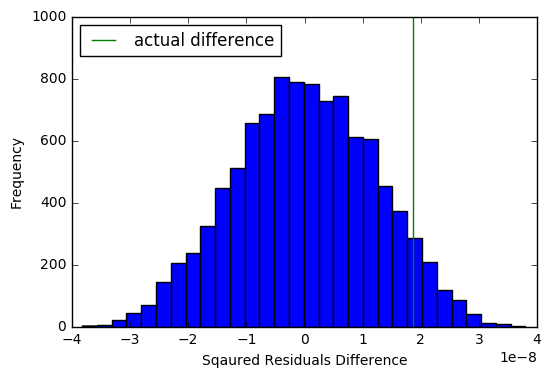

90.21600000000001


In [86]:
fig = plt.figure()
plt.hist(dif, bins=30)  # `density=False` would make counts
plt.ylabel('Frequency')
plt.plot([real_dif+0.25e-8,real_dif+0.25e-8], [0,1000], label = 'actual difference')
plt.xlabel('Sqaured Residuals Difference')
plt.title(' ')
plt.legend(loc = 2)
fig.savefig('./covid_optimisations/figures_for_paper/bootstrap_RMS_difs')
plt.show()

print np.arange(0,100.001,0.001)[percentile_index]

In [87]:
0.005*14

0.07